In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime
 
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def compute_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    
    return RSI

def compute_bollinger_bands(data, window):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = sma + (rolling_std*2)
    lower_band = sma - (rolling_std*2)
    
    return upper_band, lower_band

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def get_data(ticker_symbol, start_date, end_date):
    ticker_data = yf.Ticker(ticker_symbol)
    historical_data = ticker_data.history(start=start_date, end=end_date)
    return historical_data[['Close', 'Volume']].copy()
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

ticker_symbol = 'SPY'
ticker_data = yf.Ticker(ticker_symbol)
start_date = '2023-01-01'
end_date = '2023-10-01'
historical_data = ticker_data.history(start=start_date, end=end_date)
data = historical_data[['Close', 'Volume']].copy()
# 评估函数
def evaluate_parameters(rsi_window, sma_window, bollinger_window):
    data = get_data(ticker_symbol, start_date, end_date)
    
    data['RSI'] = compute_rsi(data['Close'], rsi_window)
    data['SMA'] = data['Close'].rolling(window=sma_window).mean()
    data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, bollinger_window)
    
    data.dropna(inplace=True)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    look_back = 10
    X, y = create_dataset(data_scaled, look_back)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    
    model = LinearRegression()
    model.fit(X_train[:, -1, :], y_train)
    y_pred = model.predict(X_test[:, -1, :])
    y_real = y_test
    
    mape = mean_absolute_percentage_error(y_real, y_pred)
    
    return mape
# 定义搜索空间
space  = [Integer(10, 20, name='rsi_window'),
          Integer(5, 21, name='sma_window'),
          Integer(7, 21, name='bollinger_window')]
# 使用贝叶斯优化
@use_named_args(space)
def objective(**params):
    return evaluate_parameters(params['rsi_window'], params['sma_window'], params['bollinger_window'])
res = gp_minimize(objective, space, n_calls=50, random_state=0)
# 获取最佳参数
best_rsi_window = res.x[0]
best_sma_window = res.x[1]
best_bollinger_window = res.x[2]
#  输出最佳参数
print("Best parameters:")
print("RSI window:", res.x[0])
print("SMA window:", res.x[1])
print("Bollinger Bands window:", res.x[2])
data = historical_data[['Close', 'Volume']].copy()
# 使用优化后的参数更新技术指标
data['RSI'] = compute_rsi(data['Close'], best_rsi_window)
data['SMA'] = data['Close'].rolling(window=best_sma_window).mean()
data['Upper_Band'], data['Lower_Band'] = compute_bollinger_bands(data, best_bollinger_window)

data.dropna(inplace=True)


# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 使用滑动窗口法创建数据集
look_back = 10
X, y = create_dataset(data_scaled, look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# 创建和训练模型
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=24),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=24),
    "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1),
    "LSTM": Sequential([
        LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(25),
        Dense(1)
    ])
}
models["LSTM"].compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
models["Linear Regression"].fit(X_train[:, -1, :], y_train)
models["Random Forest"].fit(X_train[:, -1, :], y_train)
models["Gradient Boosting"].fit(X_train[:, -1, :], y_train)
models["SVR"].fit(X_train[:, -1, :], y_train)
models["LSTM"].fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1, shuffle=False)

# 获取真实的股价数据
real_data = ticker_data.history(start='2023-10-09', end=datetime.today().strftime('%Y-%m-%d'))
real_prices = real_data['Close'].values
num_points = min(len(real_prices), 10)
def predict_future(model, initial_input, steps, is_lstm=False):
    future_predictions = []
    current_input = initial_input.copy()
    
    for i in range(steps):
        if is_lstm:
            current_prediction = model.predict(current_input[np.newaxis, :, :])[0, 0]
            future_predictions.append(current_prediction)
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction
        else:
            current_prediction = model.predict(current_input[-1, :].reshape(1, -1))
            future_predictions.append(current_prediction[0])
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = current_prediction[0]
    
    return future_predictions

# 预测股价
predictions = {}
for model_name, model in models.items():
    if model_name == "LSTM":
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
    else:
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
    
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(predictions[model_name]).reshape(-1, 1), np.zeros((len(predictions[model_name]), data.shape[1]-1))]))[:, 0]
    plt.plot(real_data.index[:num_points], predicted_prices, label=f'{model_name} Predicted Price')
# 获取每个模型的预测结果
all_predictions = []

for model_name, model in models.items():
    if model_name == "LSTM":
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
    else:
        predictions[model_name] = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
    
    predicted_prices = scaler.inverse_transform(np.hstack([np.array(predictions[model_name]).reshape(-1, 1), np.zeros((len(predictions[model_name]), data.shape[1]-1))]))[:, 0]
    all_predictions.append(predicted_prices)
    plt.plot(real_data.index[:num_points], predicted_prices, label=f'{model_name} Predicted Price')

# 计算平均预测值
average_prediction = np.mean(all_predictions, axis=0)
predictions["Average"] = average_prediction
plt.plot(real_data.index[:num_points], average_prediction, label='Average Predicted Price', color='cyan', linewidth=1.5)

plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
plt.legend()
plt.title(f'Price Prediction Comparison: {ticker_symbol}')
plt.show()

print(f"Real Prices: {real_prices[:num_points]}")
for model_name, prediction in predictions.items():
    if model_name in models or model_name == "Average":
        print(f"{model_name} Predicted Prices: {prediction}")
        
        
        
def compute_slope(data):
    """
    Compute the slope between each consecutive point in the data.
    """
    return np.diff(data)

def evaluate_models_on_slope_and_difference(models, real_prices, data_scaled, look_back, num_points):
    slope_errors = {}
    difference_errors = {}
    
    real_slopes = compute_slope(real_prices)
    
    for model_name, model in models.items():
        if model_name == "LSTM":
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
        else:
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
        
        predicted_prices = scaler.inverse_transform(np.hstack([np.array(predicted).reshape(-1, 1), np.zeros((len(predicted), data.shape[1]-1))]))[:, 0]
        
        # Compute differences between predicted and real prices
        differences = np.abs(predicted_prices - real_prices[:len(predicted_prices)])
        avg_difference = np.mean(differences)
        
        # Compute slope differences
        predicted_slopes = compute_slope(predicted_prices)
        slope_diff = np.abs(predicted_slopes - real_slopes[:len(predicted_slopes)])
        avg_slope_diff = np.mean(slope_diff)
        
        slope_errors[model_name] = avg_slope_diff
        difference_errors[model_name] = avg_difference

    return slope_errors, difference_errors

slope_errors, difference_errors = evaluate_models_on_slope_and_difference(models, real_prices, data_scaled, look_back, num_points)

# Sort models based on slope error and difference error
sorted_by_slope = sorted(slope_errors, key=slope_errors.get)
sorted_by_difference = sorted(difference_errors, key=difference_errors.get)

# 1. 使用您的方法评估模型
slope_errors, difference_errors = evaluate_models_on_slope_and_difference(models, real_prices, data_scaled, look_back, num_points)

# 2. 根据斜率和差异排序模型
best_slope_model = sorted_by_slope[0]
best_difference_model = sorted_by_difference[0]

# 3. 获取两个模型的预测值
if best_slope_model == "LSTM":
    slope_predictions = predict_future(models[best_slope_model], data_scaled[-look_back:, :], num_points, is_lstm=True)
else:
    slope_predictions = predict_future(models[best_slope_model], data_scaled[-look_back:, :], num_points, is_lstm=False)

if best_difference_model == "LSTM":
    difference_predictions = predict_future(models[best_difference_model], data_scaled[-look_back:, :], num_points, is_lstm=True)
else:
    difference_predictions = predict_future(models[best_difference_model], data_scaled[-look_back:, :], num_points, is_lstm=False)
print(f"The best models are: Slope Model - {best_slope_model}, Difference Model - {best_difference_model}")
# 4. 结合两个模型的优势来生成新的预测序列
slope_adjustments = np.insert(compute_slope(np.array(difference_predictions)), 0, 0) 
combined_predictions = np.array(difference_predictions) + slope_adjustments * slope_errors[best_slope_model]
# 反归一化预测值
combined_predictions_rescaled = scaler.inverse_transform(np.hstack([combined_predictions.reshape(-1, 1), np.zeros((len(combined_predictions), data.shape[1]-1))]))[:, 0]

print(f"Rescaled Combined Predictions: {combined_predictions_rescaled}")


# 5. 绘制图表进行比较
plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
plt.plot(real_data.index[:num_points], combined_predictions_rescaled, label='Combined Predicted Price', color='cyan', linewidth=1.5)
plt.legend()
plt.title(f'Price Prediction Comparison: {ticker_symbol}')
plt.show()

        

B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
B:\AC\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at thi

SPY: No data found, symbol may be delisted


ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by MinMaxScaler.

1/1 [==============================] - 0s 18ms/step
Rescaled Combined Predictions: [190.57465057 195.29984229 192.89723707 190.81386764 190.9338183
 189.12363544 186.66370975 184.72775234 183.25781294 185.36672156]


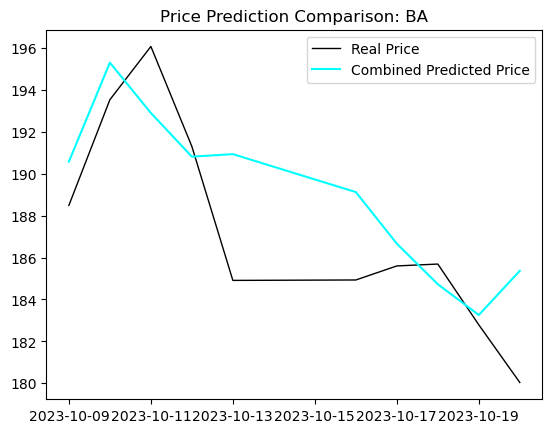

In [13]:
def compute_slope(data):
    """
    Compute the slope between each consecutive point in the data.
    """
    return np.diff(data)

def evaluate_models_on_slope_and_difference(models, real_prices, data_scaled, look_back, num_points):
    slope_errors = {}
    difference_errors = {}
    
    real_slopes = compute_slope(real_prices)
    
    for model_name, model in models.items():
        if model_name == "LSTM":
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=True)
        else:
            predicted = predict_future(model, data_scaled[-look_back:, :], num_points, is_lstm=False)
        
        predicted_prices = scaler.inverse_transform(np.hstack([np.array(predicted).reshape(-1, 1), np.zeros((len(predicted), data.shape[1]-1))]))[:, 0]
        
        # Compute differences between predicted and real prices
        differences = np.abs(predicted_prices - real_prices[:len(predicted_prices)])
        avg_difference = np.mean(differences)
        
        # Compute slope differences
        predicted_slopes = compute_slope(predicted_prices)
        slope_diff = np.abs(predicted_slopes - real_slopes[:len(predicted_slopes)])
        avg_slope_diff = np.mean(slope_diff)
        
        slope_errors[model_name] = avg_slope_diff
        difference_errors[model_name] = avg_difference

    return slope_errors, difference_errors

slope_errors, difference_errors = evaluate_models_on_slope_and_difference(models, real_prices, data_scaled, look_back, num_points)

# Sort models based on slope error and difference error
sorted_by_slope = sorted(slope_errors, key=slope_errors.get)
sorted_by_difference = sorted(difference_errors, key=difference_errors.get)

# 1. 使用您的方法评估模型
slope_errors, difference_errors = evaluate_models_on_slope_and_difference(models, real_prices, data_scaled, look_back, num_points)

# 2. 根据斜率和差异排序模型
best_slope_model = sorted_by_slope[0]
best_difference_model = sorted_by_difference[0]

# 3. 获取两个模型的预测值
if best_slope_model == "LSTM":
    slope_predictions = predict_future(models[best_slope_model], data_scaled[-look_back:, :], num_points, is_lstm=True)
else:
    slope_predictions = predict_future(models[best_slope_model], data_scaled[-look_back:, :], num_points, is_lstm=False)

if best_difference_model == "LSTM":
    difference_predictions = predict_future(models[best_difference_model], data_scaled[-look_back:, :], num_points, is_lstm=True)
else:
    difference_predictions = predict_future(models[best_difference_model], data_scaled[-look_back:, :], num_points, is_lstm=False)

# 4. 结合两个模型的优势来生成新的预测序列
# 4. 结合两个模型的优势来生成新的预测序列
slope_adjustments = np.insert(compute_slope(np.array(difference_predictions)), 0, 0) 
combined_predictions = np.array(difference_predictions) + slope_adjustments * slope_errors[best_slope_model]
# 反归一化预测值
combined_predictions_rescaled = scaler.inverse_transform(np.hstack([combined_predictions.reshape(-1, 1), np.zeros((len(combined_predictions), data.shape[1]-1))]))[:, 0]

print(f"Rescaled Combined Predictions: {combined_predictions_rescaled}")


# 5. 绘制图表进行比较
plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
plt.plot(real_data.index[:num_points], combined_predictions_rescaled, label='Combined Predicted Price', color='cyan', linewidth=1.5)
plt.legend()
plt.title(f'Price Prediction Comparison: {ticker_symbol}')
plt.show()


In [11]:
# 1. 基于斜率误差和价差误差选择最佳模型
best_slope_model = sorted_by_slope[0]
best_difference_model = sorted_by_difference[0]

# 2. 使用最佳价差模型进行预测
if best_difference_model == "LSTM":
    difference_predictions = predict_future(models[best_difference_model], data_scaled[-look_back:, :], num_points, is_lstm=True)
else:
    difference_predictions = predict_future(models[best_difference_model], data_scaled[-look_back:, :], num_points, is_lstm=False)

# 3. 结合两个模型的优势来生成新的预测序列
slope_adjustments = np.insert(compute_slope(np.array(difference_predictions)), 0, 0)
combined_predictions = np.array(difference_predictions) + slope_adjustments * slope_errors[best_slope_model]

# 4. 打印组合后的预测
print(f"Combined Predictions: {combined_predictions}")



Combined Predictions: [ 0.00298756  0.10057514  0.05095505  0.00792802  0.01040532 -0.0269797
 -0.0777836  -0.11776619 -0.14812428 -0.1045698 ]


In [12]:
# 反归一化预测值
combined_predictions_rescaled = scaler.inverse_transform(np.hstack([combined_predictions.reshape(-1, 1), np.zeros((len(combined_predictions), data.shape[1]-1))]))[:, 0]

print(f"Rescaled Combined Predictions: {combined_predictions_rescaled}")



Rescaled Combined Predictions: [190.57465057 195.29984229 192.89723707 190.81386764 190.9338183
 189.12363544 186.66370975 184.72775234 183.25781294 185.36672156]


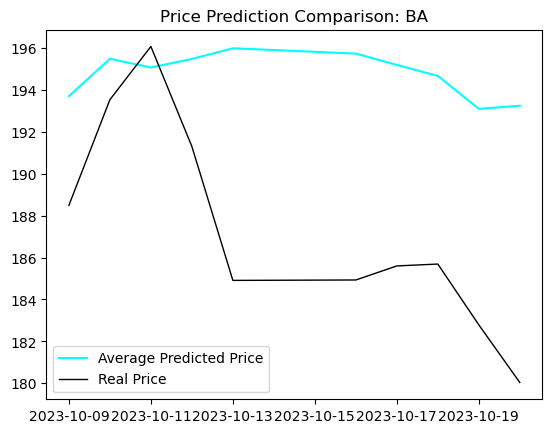

Real Prices: [188.49000549 193.52999878 196.07000732 191.30000305 184.91000366
 184.92999268 185.6000061  185.69000244 182.78999329 180.03999329]
Linear Regression Predicted Prices: [0.05078125, 0.0966796875, 0.1376953125, 0.1748046875, 0.189453125, 0.20947265625, 0.224609375, 0.23486328125, 0.22509765625, 0.23388671875]
Random Forest Predicted Prices: [0.10837366627442994, 0.15873718586662122, 0.17030161153188472, 0.1625393397439977, 0.17196939324743638, 0.1683282980183747, 0.13889209940332548, 0.12715631651295436, 0.09668843086623365, 0.09087574143135074]
Gradient Boosting Predicted Prices: [0.11302628516598484, 0.17593142758195143, 0.07908585016286426, 0.10803020143302992, 0.15339064215304068, 0.13911235186907786, 0.14424173811418126, 0.13499026088957272, 0.055639101564274186, 0.07319234815022058]
SVR Predicted Prices: [0.0029875640776402257, 0.030724125402881608, 0.03647420564217674, 0.0283607450005241, 0.023257412887770723, 0.00897890831762771, -0.015680927737010908, -0.0446958307

In [5]:
# 计算平均预测值
average_prediction = np.mean(all_predictions, axis=0)
predictions["Average"] = average_prediction
plt.plot(real_data.index[:num_points], average_prediction, label='Average Predicted Price', color='cyan', linewidth=1.5)

plt.plot(real_data.index[:num_points], real_prices[:num_points], label='Real Price', color='black', linewidth=1)
plt.legend()
plt.title(f'Price Prediction Comparison: {ticker_symbol}')
plt.show()

print(f"Real Prices: {real_prices[:num_points]}")
for model_name, prediction in predictions.items():
    if model_name in models or model_name == "Average":
        print(f"{model_name} Predicted Prices: {prediction}")

# 计算每个模型的预测与实际值之间的价差
price_diffs = {}
for model_name, prediction in predictions.items():
    diff = np.abs(prediction - real_prices[:num_points])
    price_diffs[model_name] = diff

# 为每个模型的预测和实际值计算斜率
def calculate_slope(prices):
    return np.diff(prices)

slopes = {}
real_slope = calculate_slope(real_prices[:num_points])
for model_name, prediction in predictions.items():
    slope = calculate_slope(prediction)
    slopes[model_name] = slope

# 计算预测斜率与实际斜率的差异
slope_diffs = {}
for model_name, slope in slopes.items():
    diff = np.abs(slope - real_slope)
    slope_diffs[model_name] = diff

# 对比模型
print("\nAverage Price Differences for each model:")
for model_name, diff in price_diffs.items():
    avg_diff = np.mean(diff)
    print(f"{model_name}: {avg_diff:.2f}")

print("\nAverage Slope Differences for each model:")
for model_name, diff in slope_diffs.items():
    avg_diff = np.mean(diff)
    print(f"{model_name}: {avg_diff:.2f}")

best_model_name_price = min(price_diffs, key=lambda k: np.mean(price_diffs[k]))
best_model_name_slope = min(slope_diffs, key=lambda k: np.mean(slope_diffs[k]))

print(f"\nThe best model based on average price difference is: {best_model_name_price}")
print(f"The best model based on average slope difference is: {best_model_name_slope}")
